In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils

In [2]:
OUTPUT_DIR = "/data/patrick_res/glm"

session = 20180803
separate_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_separate.pickle"))
interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_interaction.pickle"))
shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_shuffles.pickle"))

# interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_card_interaction.pickle"))
# shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_card_shuffles.pickle"))

In [3]:
stats = glm_utils.calculate_sig_stats(shuffled_res, 0.05, 15)

In [4]:
feedback_idxs = np.arange(13, 28, 1)
choice_idxs = np.arange(0, 13, 1)

In [5]:
stats = glm_utils.calculate_sig_stats(shuffled_res, 0.05, 15)
merged = pd.merge(interaction_res, stats, on=["UnitID", "TimeBins"])
# TODO: HACK!! make general solution here, get rid of TimeBins disaster
merged["TimeIdxs"] = (merged["TimeBins"] * 10).astype(int)
merged = merged[merged.TimeIdxs.isin(feedback_idxs)]
def assess_unit(unit_group):
    print(unit_group.TimeBins.unique())
    sig = unit_group.score > unit_group.sig_bound
    return pd.Series({"IsSig": np.any(sig)})


In [6]:
fb_units_sig = glm_utils.identify_significant_units(interaction_res, shuffled_res, feedback_idxs)
choice_units_sig = glm_utils.identify_significant_units(interaction_res, shuffled_res, choice_idxs)

In [7]:
len(fb_units_sig[fb_units_sig.IsSig])

28

In [8]:
fb_units_sig = fb_units_sig[fb_units_sig.IsSig]

In [9]:
pos = spike_utils.get_unit_positions_per_sess(session)
pos = spike_utils.get_manual_structure(pos)

In [ ]:
for unit in separate_res.UnitID.unique():
    fig, ax = plt.subplots()
    unit_pos = pos[pos.UnitID == unit].manual_structure.unique()[0]
    unit_separate = separate_res[separate_res.UnitID == unit].score
    unit_interaction = interaction_res[interaction_res.UnitID == unit].score
    sig_bound = stats[stats.UnitID == unit].sig_bound

    time_bins = interaction_res[interaction_res.UnitID == unit].TimeBins - 1.3

    ax.plot(time_bins, unit_separate, label="Separate Score")
    ax.plot(time_bins, unit_interaction, label="Interaction Score")
    ax.plot(time_bins, sig_bound, label="Significance Bound")

    ax.set_title(f"Unit {unit} ({unit_pos})")
    ax.legend()
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Fraction of Deviance Explained")

### Assess as a population, how many neurons fit this criteria

In [8]:
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [9]:
def find_sig_units_per_session(row, time_idxs, card=False):
    session = row.session_name
    if card: 
        interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_card_interaction.pickle"))
        shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_card_shuffles.pickle"))
    else: 
        interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_interaction.pickle"))
        shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_shuffles.pickle"))        
    units_sig = glm_utils.identify_significant_units(interaction_res, shuffled_res, time_idxs)
    sig_units = units_sig[units_sig.IsSig]
    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)
    filtered_pos = pos[pos.UnitID.isin(sig_units.UnitID)]
    return filtered_pos

In [10]:
choice_card_units = pd.concat(sessions.apply(lambda x: find_sig_units_per_session(x, choice_idxs, card=True), axis=1).values)
feedback_card_units = pd.concat(sessions.apply(lambda x: find_sig_units_per_session(x, feedback_idxs, card=True), axis=1).values)
choice_rpe_units = pd.concat(sessions.apply(lambda x: find_sig_units_per_session(x, choice_idxs, card=False), axis=1).values)
feedback_rpe_units = pd.concat(sessions.apply(lambda x: find_sig_units_per_session(x, feedback_idxs, card=False), axis=1).values)


In [11]:
print(len(choice_card_units))
print(len(feedback_card_units))
print(len(choice_rpe_units))
print(len(feedback_rpe_units))

151
106
225
445


In [148]:
feedback_rpe_units.to_pickle("/data/patrick_res/state_update_subpop.pickle")

(0.0, 1.0)

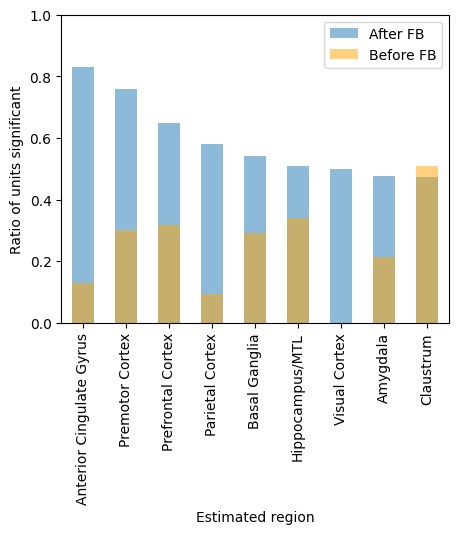

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))
portions = spike_utils.get_subpop_ratios_by_region(feedback_rpe_units, sessions)
after_portions = portions[portions.index != "unknown"]
after_portions = after_portions.rename(columns={"Ratio": "AfterRatio"})

portions = spike_utils.get_subpop_ratios_by_region(choice_rpe_units, sessions)
before_portions = portions[portions.index != "unknown"]
before_portions = before_portions.rename(columns={"Ratio": "BeforeRatio"})

portions = pd.merge(after_portions, before_portions, on="manual_structure")
portions.AfterRatio.plot.bar(ax=ax, alpha=0.5, label="After FB")
portions.BeforeRatio.plot.bar(ax=ax, color="orange", alpha=0.5, label="Before FB")

ax.legend()
ax.set_xlabel("Estimated region")
ax.set_ylabel("Ratio of units significant")
ax.set_ylim(0, 1)

In [32]:
portions

,SubpopCount_x,PopCount_x,Ratio_x,SubpopCount_y,PopCount_y,Ratio_y
manual_structure,,,,,,
Anterior Cingulate Gyrus,39,47,0.829787,6.0,47,0.127660
Premotor Cortex,38,50,0.760000,15.0,50,0.300000
Prefrontal Cortex,134,207,0.647343,66.0,207,0.318841
Parietal Cortex,50,86,0.581395,8.0,86,0.093023
Basal Ganglia,26,48,0.541667,14.0,48,0.291667
Hippocampus/MTL,91,179,0.508380,61.0,179,0.340782
Visual Cortex,4,8,0.500000,0.0,8,0.000000
Amygdala,20,42,0.476190,9.0,42,0.214286
Claustrum,25,53,0.471698,27.0,53,0.509434


Text(0.5, 1.0, 'After feedback')

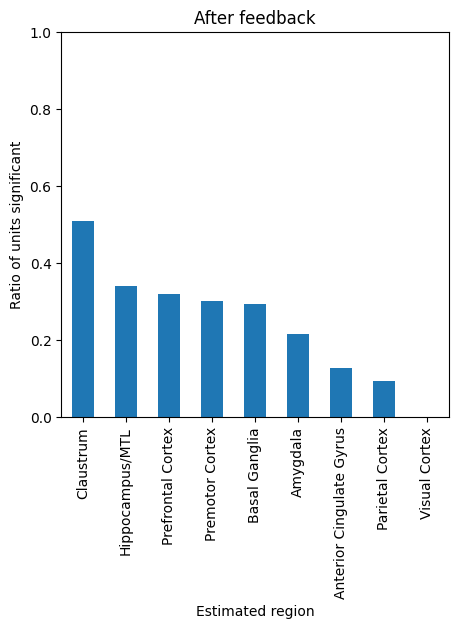

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
portions = spike_utils.get_subpop_ratios_by_region(choice_rpe_units, sessions)
portions = portions[portions.index != "unknown"]
ax = portions.Ratio.plot.bar(ax=ax)
ax.set_xlabel("Estimated region")
ax.set_ylabel("Ratio of units significant")
ax.set_ylim(0, 1)
ax.set_title("After feedback")

<Axes: xlabel='manual_structure'>

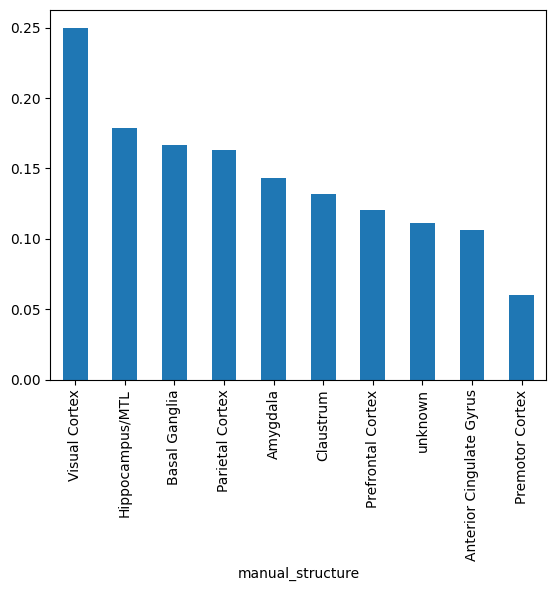

In [12]:
portions = spike_utils.get_subpop_ratios_by_region(feedback_card_units, sessions)
portions.Ratio.plot.bar()

<Axes: xlabel='manual_structure'>

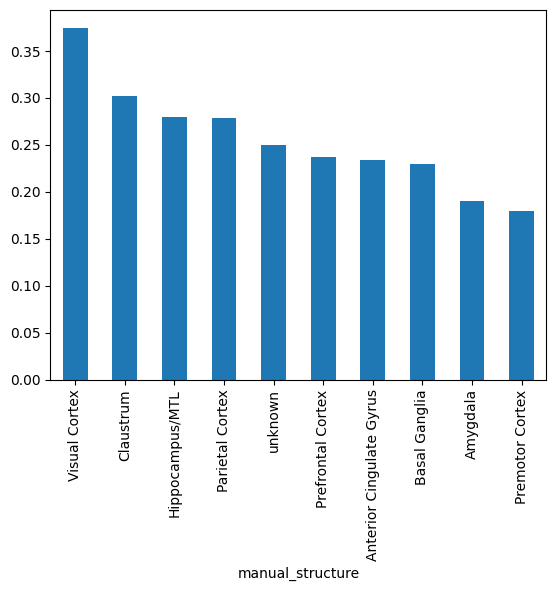

In [152]:
portions = spike_utils.get_subpop_ratios_by_region(choice_card_units, sessions)
portions.Ratio.plot.bar()

how many units are shared in rpe interaction selective pre feedback and postfeedback 

In [ ]:
shared_rpe_units = choice_rpe_units[choice_rpe_units.PseudoUnitID.isin(feedback_rpe_units.PseudoUnitID)]

In [ ]:
len(shared_rpe_units)

In [ ]:
card_rpe_fb_units = feedback_card_units[feedback_card_units.PseudoUnitID.isin(feedback_rpe_units.PseudoUnitID)]

In [ ]:
len(card_rpe_fb_units)

In [ ]:
card_rpe_choice_units = choice_card_units[choice_card_units.PseudoUnitID.isin(choice_rpe_units.PseudoUnitID)]

In [ ]:
len(card_rpe_choice_units)